# Attack CNN Malware Detector 

## Fast Gradient Sign Method
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

# import

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import backend, losses

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# run this cell twice if u wanna ignore the warning msg

In [3]:
# set some param for plot
mpl.rcParams['figure.figsize'] = (3, 3)
mpl.rcParams['axes.grid'] = False

# load 


## the model we wanna attack

In [5]:
# load the model
model = keras.models.load_model('/mnt/bigDisk/applebanana/code/API_IMG/new_CNN_model')

# run this cell twice if u wanna ignore the warning msg

## testing set
* x_test, y_test
    - x_test[0:50] : benignware img (y_test[0:50]=0)
    - x_test[50:100] : malware img (y_test[0:50]=1)

In [6]:
# familyName = ['benign','mirai']
# familyLabel = {'benign':0,'mirai':1}

# size of each img = 9*9, 3 for R,G,B
x_test = np.empty([100,9,9,3], dtype=np.float32)
y_test = np.empty([100,2], dtype=np.float32)
count=0
for i in range(50,100):
    y_test[count,:] = [1,0]
    fname = "benign_" + str(i) + ".npy" 
    # we need to /255 for each pixel in the img cuz the dtype is float
    x_test[count,:,:,:]=np.load('/mnt/bigDisk/applebanana/code/API_IMG/benign_img_9cate/'+fname)/255
    count+=1
for i in range(50,100):
    y_test[count,:] = [0,1]
    fname = "mirai_" + str(i) + ".npy"
    # we need to /255 for each pixel in the img cuz the dtype is float
    x_test[count,:,:,:]=np.load('/mnt/bigDisk/applebanana/code/API_IMG/malware_img_9cate/'+fname)/255
    count+=1

# FGSM

## try to create the adversarial image

### func def.

In [8]:
def create_adversarial_pattern(input_image, y_true):
  '''
  param.
    input_image: Original Input Img
    y_true: Original Input Label
  return.
    the noise(adversarial pattern) for this img
  '''
  # transform the img(x[i]) 
  #   1. shape (9,9,3) -> (1,9,9,3)
  #   2. to tf.tensor
  tmp =  np.empty([1,9,9,3], dtype=np.float32)
  tmp[0,:,:,:] = input_image
  input_image = tmp
  input_image = tf.convert_to_tensor(input_image)
  input_image = tf.cast(input_image, tf.float32)
  
  # get the signed_grad
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    y_pred = model(input_image)
    # print(y_pred,y_true)
    loss = losses.categorical_crossentropy(y_true, y_pred[0])
    # print(loss)
    
  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # print(gradient)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

test the func create_adversarial_pattern

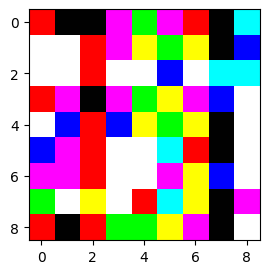

In [10]:
# Get the input label of the image.
perturbations = create_adversarial_pattern(x_test[55], y_test[55])
plt.imshow(tf.cast(perturbations[0], tf.uint8))
plt.show()

try to add noise to an malware img

eps= 0
tf.Tensor([[4.6491919e-06 9.9999535e-01]], shape=(1, 2), dtype=float32)


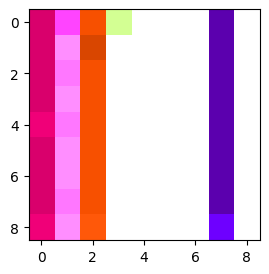

eps= 0.15
tf.Tensor([[0.0060196 0.9939804]], shape=(1, 2), dtype=float32)


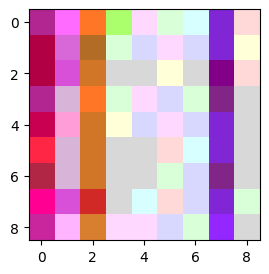

eps= 0.16
tf.Tensor([[0.01312317 0.98687685]], shape=(1, 2), dtype=float32)


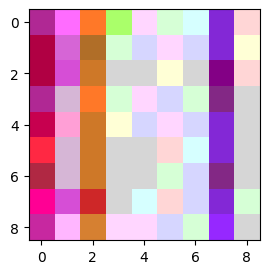

eps= 0.17
tf.Tensor([[0.02833599 0.9716641 ]], shape=(1, 2), dtype=float32)


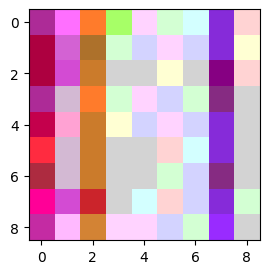

eps= 0.18
tf.Tensor([[0.06046394 0.93953604]], shape=(1, 2), dtype=float32)


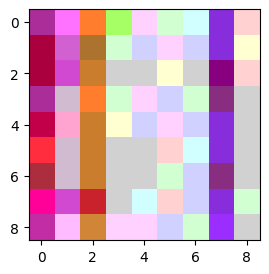

eps= 0.2
tf.Tensor([[0.23852597 0.761474  ]], shape=(1, 2), dtype=float32)


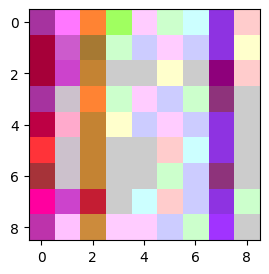

In [11]:
epsilons = [0, 0.15, 0.16, 0.17, 0.18, 0.2]

for i, eps in enumerate(epsilons):
  print('eps=',eps)
  adv_x = x_test[55] + eps * perturbations[0]
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  # print(adv_x)
  tmp =  np.empty([1,9,9,3], dtype=np.float32)
  tmp[0,:,:,:] = adv_x
  print(model(tmp)) # print the prediction of the model so we can know the performance
  plt.figure()
  plt.imshow(adv_x)
  plt.show()


# AEs generation (all the malware img)

In [12]:
# gen the adversarial pattern of each malware img
adversarial_pattern = np.empty([50,9,9,3], dtype=np.float32) # init

# get the noise for each img
for i in range(0,50):
        adversarial_pattern[i] = create_adversarial_pattern(x_test[i+50],y_test[i+50])


adversarial_example = dict() # key: eps, val: AE
# e.g. adversarial_example[0.1][3] = original_img[3] + 0.1 * noise[3]

# generate AE 
epsilons = [0.01, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25]
for eps in epsilons:
    adversarial_example[eps] = np.empty([50,9,9,3], dtype=np.float32)
    for i in range(0,50):
        adv_x = x_test[i+50] + eps * adversarial_pattern[i]
        adv_x = tf.clip_by_value(adv_x, 0, 1)
        adversarial_example[eps][i] = adv_x

In [13]:
# import pickle
# with open('adversarial_example.pkl', 'wb') as f:
#     pickle.dump(adversarial_example, f)


# attack CNN model 
## use AEs with different epsilon as input, explore the result

In [15]:
result = dict()
# e.g. result[0.1] means the eps of AE is 0.1
for eps in epsilons:
    result[eps] = model.evaluate(adversarial_example[eps],y_test[50:])

2/2 [==============================] - 0s 1ms/step - loss: 5.5320 - accuracy: 0.0000e+00


In [17]:
result

{0.01: [0.0109684057533741, 1.0],
 0.05: [0.14041966199874878, 0.9200000166893005],
 0.075: [0.37086713314056396, 0.8399999737739563],
 0.1: [0.7327786087989807, 0.7599999904632568],
 0.15: [1.7225086688995361, 0.6800000071525574],
 0.2: [3.090104103088379, 0.36000001430511475],
 0.25: [5.531953811645508, 0.0]}

## details about all the sample

In [18]:
eps = 0.075
for i in range(50):
    tmp = np.empty([1,9,9,3],dtype=np.float32)
    tmp[0] = adversarial_example[eps][i]
    result_tmp = model(tmp)
    print(i,result_tmp)

0 tf.Tensor([[0.01337456 0.98662543]], shape=(1, 2), dtype=float32)
1 tf.Tensor([[5.0066843e-05 9.9994993e-01]], shape=(1, 2), dtype=float32)
2 tf.Tensor([[2.8010548e-04 9.9971992e-01]], shape=(1, 2), dtype=float32)
3 tf.Tensor([[7.7816025e-05 9.9992216e-01]], shape=(1, 2), dtype=float32)
4 tf.Tensor([[4.0326337e-05 9.9995971e-01]], shape=(1, 2), dtype=float32)
5 tf.Tensor([[7.4237396e-05 9.9992573e-01]], shape=(1, 2), dtype=float32)
6 tf.Tensor([[8.5604953e-04 9.9914396e-01]], shape=(1, 2), dtype=float32)
7 tf.Tensor([[2.353964e-05 9.999765e-01]], shape=(1, 2), dtype=float32)
8 tf.Tensor([[2.173483e-04 9.997826e-01]], shape=(1, 2), dtype=float32)
9 tf.Tensor([[7.814135e-05 9.999218e-01]], shape=(1, 2), dtype=float32)
10 tf.Tensor([[0.96896744 0.03103255]], shape=(1, 2), dtype=float32)
11 tf.Tensor([[6.213760e-05 9.999379e-01]], shape=(1, 2), dtype=float32)
12 tf.Tensor([[0.10869297 0.891307  ]], shape=(1, 2), dtype=float32)
13 tf.Tensor([[9.937081e-05 9.999006e-01]], shape=(1, 2), dty

## find the sample which is easy to present

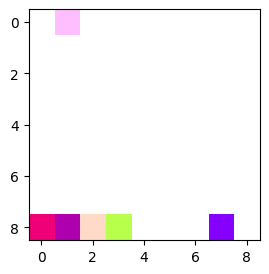

In [69]:
plt.imshow(x_test[50+14])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


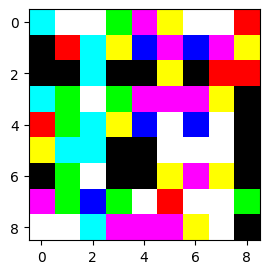

In [37]:
plt.imshow(adversarial_pattern[14])

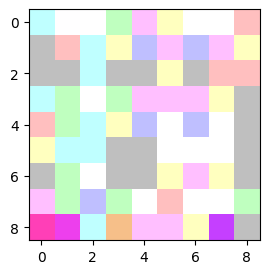

In [54]:
plt.imshow(adversarial_example[0.25][14])

# try to remain the white area (another AE)

In [19]:
def AE_gen_remain_white_area(input_img,eps,perturbations):
    '''
    param. img, eps, noise(perturbations)
    return. a img with adv pattern
    '''
    tmp =  np.zeros([1,9,9,3], dtype=np.float32)
    
    for p in range(9):
        for j in range(9):
            for k in range(3):
                # if the pixel not white -> add noise
                # else -> keep it white
                if input_img[p][j][k] != 1.0:
                    tmp[0][p][j][k] = input_img[p][j][k] + eps * perturbations[p][j][k]
                else:
                    tmp[0][p][j][k] = 1
    return tmp[0]

In [20]:
# gen the adversarial pattern of each img
adversarial_pattern = np.empty([50,9,9,3], dtype=np.float32)
for i in range(0,50):
        adversarial_pattern[i] = create_adversarial_pattern(x_test[i+50],y_test[i+50])

adversarial_example = dict() # key: eps, val: AEs
epsilons = [0.01, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25]
for eps in epsilons:
    adversarial_example[eps] = np.empty([50,9,9,3], dtype=np.float32)
    for i in range(0,50):
        adv_x = AE_gen_remain_white_area(x_test[i+50], eps, adversarial_pattern[i])
        adv_x = tf.clip_by_value(adv_x, 0, 1)
        adversarial_example[eps][i] = adv_x

In [21]:
# with open('remain_white_adversarial_example.pkl', 'wb') as f:
#     pickle.dump(adversarial_example, f)

In [22]:
result = dict()
for eps in epsilons:
    result[eps] = model.evaluate(adversarial_example[eps],y_test[50:])

2/2 [==============================] - 0s 2ms/step - loss: 0.8816 - accuracy: 0.7600


In [23]:
result

{0.01: [0.006796030793339014, 1.0],
 0.05: [0.02268688939511776, 1.0],
 0.075: [0.04879584163427353, 0.9599999785423279],
 0.1: [0.09313542395830154, 0.9399999976158142],
 0.15: [0.2420046180486679, 0.9200000166893005],
 0.2: [0.5080183148384094, 0.8199999928474426],
 0.25: [0.8815600872039795, 0.7599999904632568]}

In [24]:
for i in range(50):
    tmp = np.empty([1,9,9,3],dtype=np.float32)
    tmp[0] = adversarial_example[0.075][i]
    result_tmp = model(tmp)
    print(i,result_tmp)

0 tf.Tensor([[0.00219374 0.99780625]], shape=(1, 2), dtype=float32)
1 tf.Tensor([[1.5097094e-05 9.9998486e-01]], shape=(1, 2), dtype=float32)
2 tf.Tensor([[5.7831654e-05 9.9994218e-01]], shape=(1, 2), dtype=float32)
3 tf.Tensor([[2.102019e-05 9.999790e-01]], shape=(1, 2), dtype=float32)
4 tf.Tensor([[1.1258588e-05 9.9998879e-01]], shape=(1, 2), dtype=float32)
5 tf.Tensor([[1.9814877e-05 9.9998021e-01]], shape=(1, 2), dtype=float32)
6 tf.Tensor([[1.2569550e-04 9.9987423e-01]], shape=(1, 2), dtype=float32)
7 tf.Tensor([[4.4335084e-06 9.9999559e-01]], shape=(1, 2), dtype=float32)
8 tf.Tensor([[4.2658696e-05 9.9995732e-01]], shape=(1, 2), dtype=float32)
9 tf.Tensor([[2.1782775e-05 9.9997818e-01]], shape=(1, 2), dtype=float32)
10 tf.Tensor([[0.3673621  0.63263786]], shape=(1, 2), dtype=float32)
11 tf.Tensor([[1.6802709e-05 9.9998319e-01]], shape=(1, 2), dtype=float32)
12 tf.Tensor([[0.00420449 0.9957955 ]], shape=(1, 2), dtype=float32)
13 tf.Tensor([[2.3090955e-05 9.9997687e-01]], shape=(1,

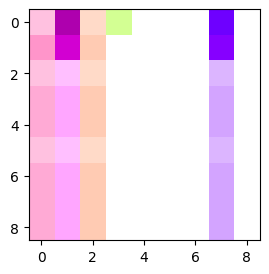

In [25]:
plt.imshow(x_test[50+19])

0.01


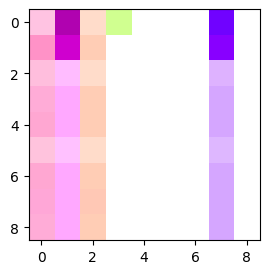

0.05


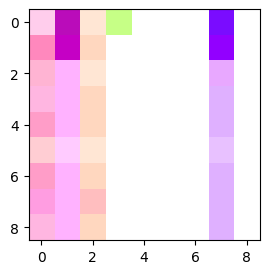

0.075


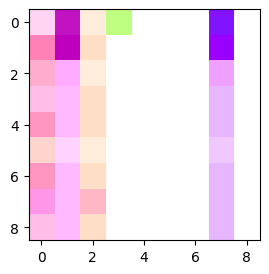

0.1


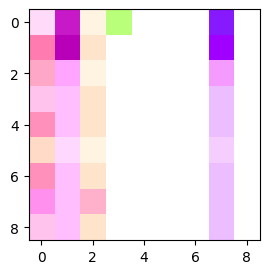

0.15


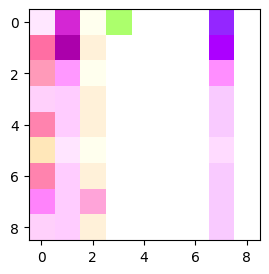

0.2


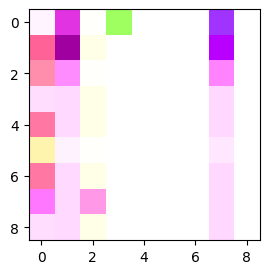

0.25


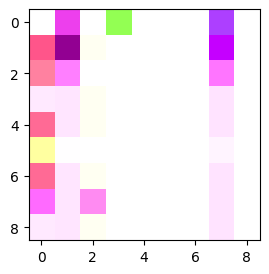

In [29]:
for eps in epsilons:
    print(eps)
    plt.imshow(adversarial_example[eps][19])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


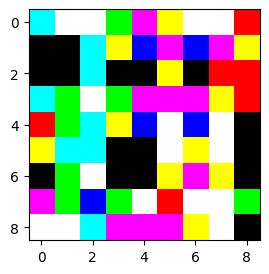

In [27]:
plt.imshow(adversarial_pattern[19])